# Connectionism
In this assignment, you will implement a connectionist model of memory storage and retrieval. Before starting work on the assigment, you should read the following paper:

- McClelland, J. L. (1981). Retrieving general and specific knowledge from stored knowledge of specifics. *Proceedings of the Third Annual Conference of the Cognitive Science Society,* 170-172. [[link]](https://stanford.edu/~jlmcc/papers/McClelland81.pdf)

Note that all example images in this Colab notebook are just that: example images. Your data can lead to different figures and conclusions than the data used to create these examples.

<figure>
<img src="https://web.stanford.edu/group/pdplab/pdphandbook/jetsdiagram.png" alt="Frequency plot" width=400>
</figure>



In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Preparing your data and setting up the network

The dataset listed in the paper consists of 27 gang members with each 6 attributes:


1.   Name (27 unique names)
2.   Gang (2 gangs)
3.   Age (3 age brackets)
4.   Education level (3 education levels)
5.   Marital status (3 marital statuses)
6.   Occupation (3 occupations)

This means that the total number of nodes in our network is $27+27+2+3+3+3+3=68$. Nodes are either excitatory or inhibitory connected to each other. We know from the paper that nodes *within* an attribute inhibit each other. Using a $68 \times 68$ matrix we can encode the complete dataset. To save you time, we are providing a binary matrix as a CSV file, indicating whether or not there is an *excitatory* connection between two nodes.

### Assignment 1.1
Load the data and take a look at its contents. The input is represented as a matrix of size $68 \times 68$. Note that [name]-name refers to a property node, while [name] refers to an instance node.




In [2]:
!wget -qO dataset.csv https://surfdrive.surf.nl/files/index.php/s/vxOY3pFjSnP5KoQ/download

# Assignment 1.1
# Load data
data = pd.read_csv("dataset.csv", index_col=0)
print(data.shape)
data.head()

(68, 68)


,Art,Al,Sam,Clyde,Mike,Jim,Greg,John,Doug,Lance,...,Nick-name,Don-name,Ned-name,Karl-name,Ken-name,Earl-name,Rick-name,Ol-name,Neal-name,Dave-name
Art,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Al,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Clyde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mike,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Assignment 1.2
Now you will need to represent inhibitory connections between property nodes. Think about your design choices.



In [3]:
# Assignment 1.2
inhibitory_matrix = np.zeros_like(data.values)

# Example cohorts based on dataset structure (adjust these index ranges if needed):
# Property cohorts: (just an example structure — adjust based on dataset)
# Gang: 27-29, Age: 29-32, Edu: 32-35, Marital: 35-38, Occupation: 38-41, etc.
cohorts = [
    range(27, 29),   # Gang
    range(29, 32),   # Age
    range(32, 35),   # Education
    range(35, 38),   # Marital status
    range(38, 41)    # Occupation
]

# Add inhibition: -1 between all nodes in the same cohort except on the diagonal
for cohort in cohorts:
    for i in cohort:
        for j in cohort:
            if i != j:
                inhibitory_matrix[i, j] = -1

# Convert to DataFrame to keep same structure
inhibitory_matrix = pd.DataFrame(inhibitory_matrix, index=data.index, columns=data.columns)
inhibitory_matrix.head()

,Art,Al,Sam,Clyde,Mike,Jim,Greg,John,Doug,Lance,...,Nick-name,Don-name,Ned-name,Karl-name,Ken-name,Earl-name,Rick-name,Ol-name,Neal-name,Dave-name
Art,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Al,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Clyde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mike,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Assignment 1.3
It is now time to implement the network as a class named `IACModel`. The class should contain two methods `update_activations()` and `run()` in addition to its special method `__init__()`. You do not yet have to implement the two methods, you will do that later, but you do have to implement `__init__()`. What would you put in there?


In [4]:
# Assignment 1.3
class IACModel:
    def __init__(self, excitatory_matrix, inhibitory_matrix, resting_activation=0.1):
        self.excitatory_matrix = excitatory_matrix.values
        self.inhibitory_matrix = inhibitory_matrix.values
        self.n_nodes = self.excitatory_matrix.shape[0]
        self.activations = np.full(self.n_nodes, resting_activation)
        
        # Parameters from the paper
        self.E = 0.1   # Excitation weight
        self.I = 0.03  # Inhibition weight
        self.D = 0.05  # Decay rate
        self.R = resting_activation  # Resting activation
        self.M = 1.0   # Max activation
        self.m = -0.2  # Min activation

## Part 2. System dynamics

The *dynamics* of a system refer to its changes in state over time. Each node's activation depends on the activations of the nodes that are connected to it through excitatory and inhibitory connections.

But this is not all. A node's activation *decays* over time, according to $D(a_i(t)-R)$ with decay parameter $D$ and resting value $R$. Let's look at how this works.

### Assignment 2.1

Assume $D=0.05$ and $R=0.1$. Start by implementing a node with activation $A = 0.1$ at time $t=0$. Have the node's activation decay according to the above definition. At time $t=5$ you will excite the node by setting its activation to $0.9$. Run 100 timesteps, then plot the activation over time. This should look something like:


<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/PCFawx2t62kCzkL/download" alt="Frequency plot" width=400>
</figure>



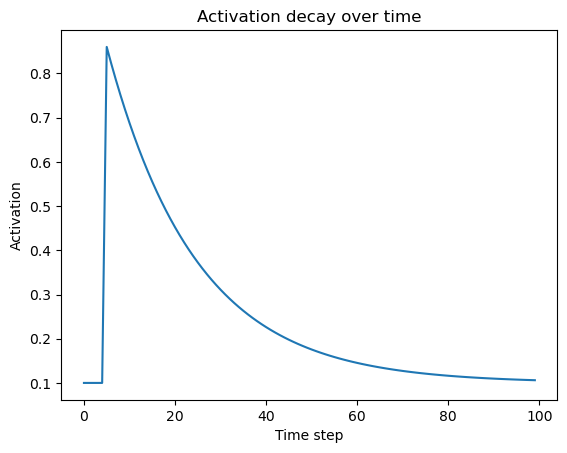

In [5]:
# Assignment 2.1
R = 0.1
D = 0.05
timesteps = 100
activations = []

# Start with A = 0.1 at t=0
A = 0.1

for t in range(timesteps):
    if t == 5:
        A = 0.9  # External excitation at t=5
    # Decay equation: dA = -D * (A - R)
    dA = -D * (A - R)
    A += dA
    activations.append(A)

# Plot the decay
plt.plot(range(timesteps), activations)
plt.xlabel("Time step")
plt.ylabel("Activation")
plt.title("Activation decay over time")
plt.show()

So this is how one node's activation changes over time. Now let's implement our `update_activations()` and `run()` methods to reflect the dynamics described in the paper.

Let's take a look at the paper. Specifically, the net input to node $i$ at time $t$ is given by:

$\textit{input}{_i}(t) = p_i(t) + E\displaystyle\sum_je_{ij}(t) - I\displaystyle\sum_ji_{ij}(t)$

with all necessary symbols explained in the paper (p. 171). In short, the input is determined by (1) the external input going into the system by means of a probe, and (2) the activation of a node's connected neighbors.

Then, once we know $\textit{input}{_i}(t)$, we can calculate $\textit{effect}{_i}(t)$ using this definition from the paper:

<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/WSFamjOWq6cdU7n/download" alt="Frequency plot" width=600>
</figure>

Finally, we update the activations of our nodes using:

<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/1RTgbNittDuk46h/download" alt="Frequency plot" width=400>
</figure>

Now you have all the information (together with the paper) to implement the `update_activations()` method in your class. The only thing the `run()` method needs to do is to loop over timesteps (let's say 500) and iteratively call the `update_activations()` method. Implement both.

In [6]:
class IACModel:
    def __init__(self, excitatory_matrix, inhibitory_matrix, resting_activation=0.1):
        self.excitatory_matrix = excitatory_matrix.values
        self.inhibitory_matrix = inhibitory_matrix.values
        self.n_nodes = self.excitatory_matrix.shape[0]
        self.activations = np.full(self.n_nodes, resting_activation)
        
        # Parameters from the paper
        self.E = 0.1   # Excitation weight
        self.I = 0.03  # Inhibition weight
        self.D = 0.05  # Decay rate
        self.R = resting_activation  # Resting activation
        self.M = 1.0   # Max activation
        self.m = -0.2  # Min activation

    # Add to your IACModel class:
    def update_activations(self, probe=None):
        # probe is an array of same length as nodes, 0s except where externally activated
        if probe is None:
            probe = np.zeros(self.n_nodes)
        
        # Calculate net input for each node
        excitatory_input = self.excitatory_matrix @ self.activations
        inhibitory_input = self.inhibitory_matrix @ self.activations
        net_input = probe + self.E * excitatory_input - self.I * inhibitory_input
        
        # Update each node’s activation according to effect and decay
        for i in range(self.n_nodes):
            if net_input[i] >= 0:
                effect = (self.M - self.activations[i]) * net_input[i]
            else:
                effect = (self.activations[i] - self.m) * net_input[i]
            
            # Update activation with effect and decay
            delta = effect - self.D * (self.activations[i] - self.R)
            self.activations[i] += delta
            
            # Clip activation between min and max
            self.activations[i] = np.clip(self.activations[i], self.m, self.M)

    def run(self, probe=None, timesteps=500):
        for _ in range(timesteps):
            self.update_activations(probe)


## Part 3. Probing the network and getting information out

For this part, you will create bar graphs of activations. For example, the figure below:


<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/srMB2wDLzywFo1S/download" alt="Frequency plot" width=400>
</figure>

Let's now take a look at the paper (p. 171) under Examples of the model's behavior.

Probe the network with *Jets*, similar to the paper. Make a figure of the activations of all the property nodes after 500 timesteps.

Now probe the property node of the name *George*. Make a figure of all non-name property nodes.

Finally, probe *Age 20s* and *JH*, similar to the paper. Make a figure showing the activations of the instance nodes.



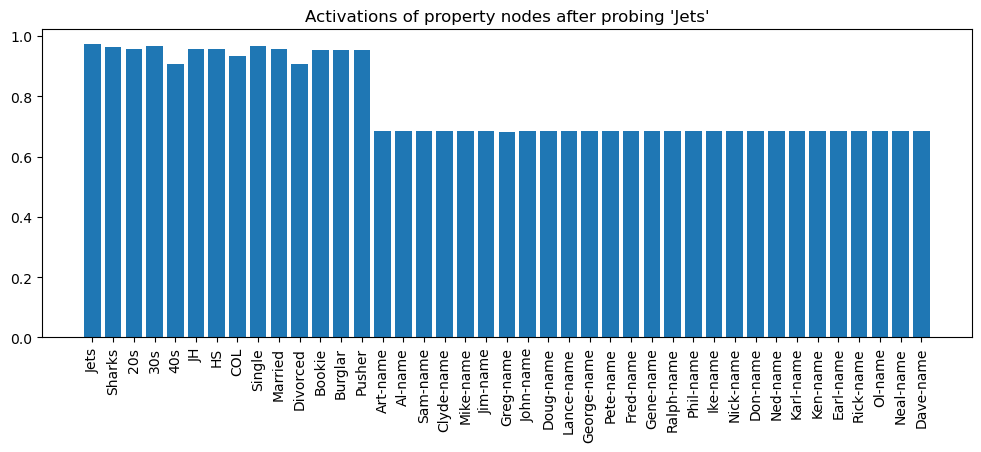

In [7]:
# 3.1 Probe the network with 'Jets'
model = IACModel(data, inhibitory_matrix)

# Find index of the 'Jets' property node
jets_idx = data.index.get_loc('Jets')

# Create probe
probe = np.zeros(model.n_nodes)
probe[jets_idx] = 0.2  # external activation as in paper

# Run model
model.run(probe, timesteps=500)

# Plot property node activations (properties are typically index >= 27)
plt.figure(figsize=(12, 4))
plt.bar(data.index[27:], model.activations[27:])
plt.xticks(rotation=90)
plt.title("Activations of property nodes after probing 'Jets'")
plt.show()

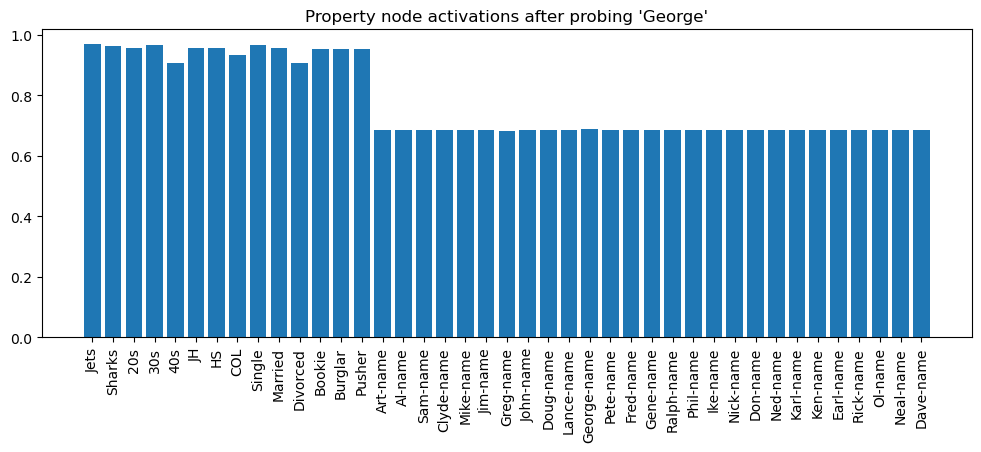

In [8]:
# 3.2 Probe the network with 'George'
model = IACModel(data, inhibitory_matrix)

# Find index for 'George'
george_idx = data.index.get_loc('George')

probe = np.zeros(model.n_nodes)
probe[george_idx] = 0.2

# Run the network
model.run(probe, timesteps=500)

# Plot only non-name property nodes
plt.figure(figsize=(12, 4))
plt.bar(data.index[27:], model.activations[27:])
plt.xticks(rotation=90)
plt.title("Property node activations after probing 'George'")
plt.show()


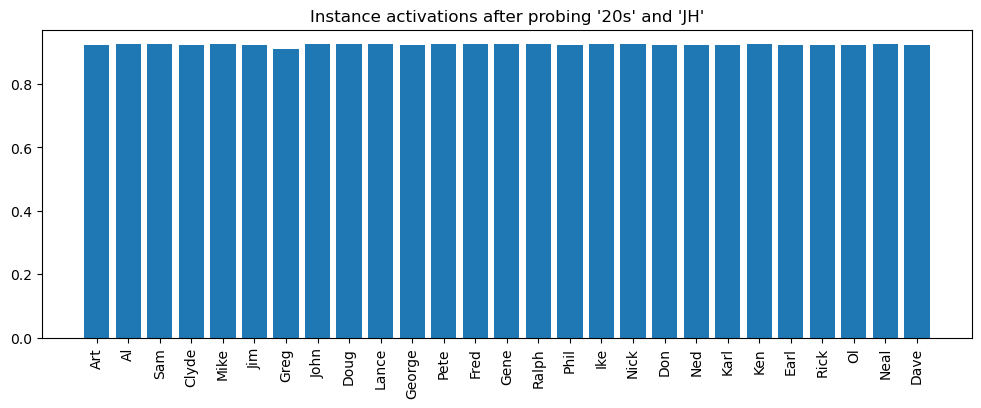

In [9]:
# 3.3 Probe with '20s' and 'JH'
model = IACModel(data, inhibitory_matrix)

age_20_idx = data.index.get_loc("20s")
jh_idx = data.index.get_loc("JH")  # adjust if column name differs

probe = np.zeros(model.n_nodes)
probe[age_20_idx] = 0.2
probe[jh_idx] = 0.2

model.run(probe, timesteps=500)

# Plot instance node activations (0–26)
plt.figure(figsize=(12, 4))
plt.bar(data.index[:27], model.activations[:27])
plt.xticks(rotation=90)
plt.title("Instance activations after probing '20s' and 'JH'")
plt.show()


## Conclusion
Well done! You have implemented McClellands original IAC network, the (re-)birth of connectionism and artificial neural networks!